In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv(os.path.join('..', '..', 'data', 'input', 'housing_dataset.csv'), header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


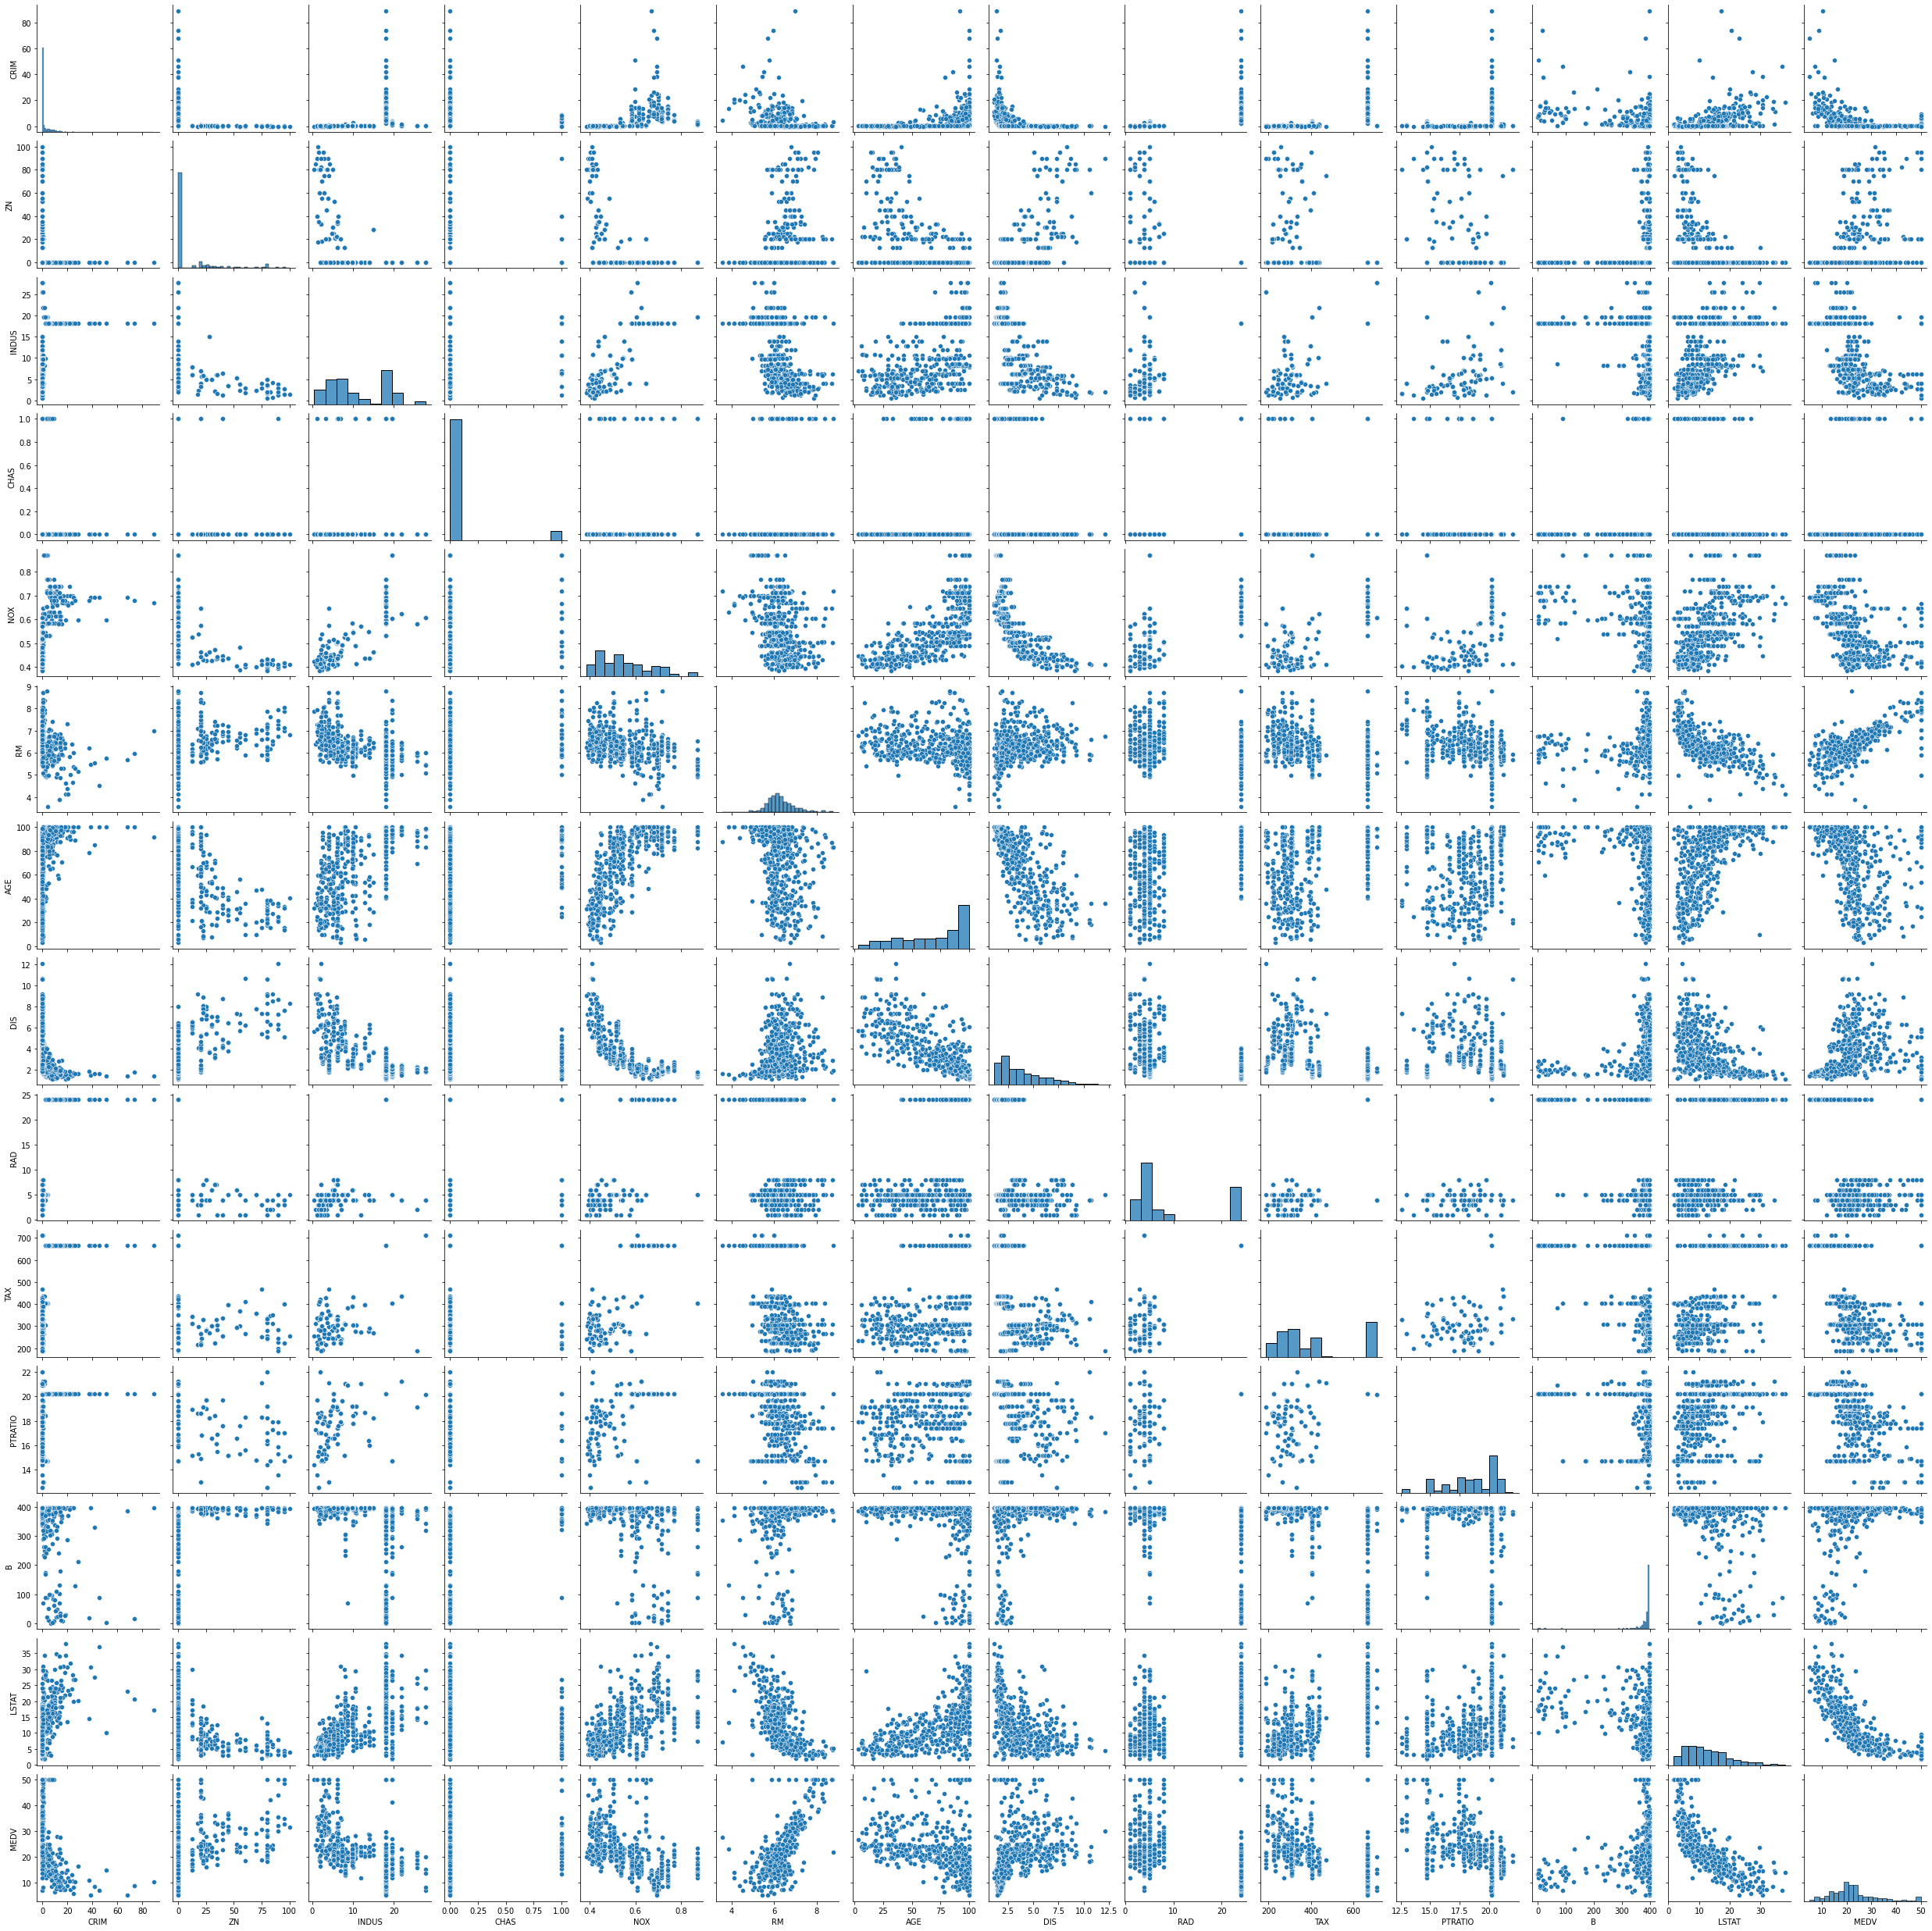

In [3]:
sns.pairplot(df)

(<Figure size 1080x1080 with 2 Axes>, <AxesSubplot:>)

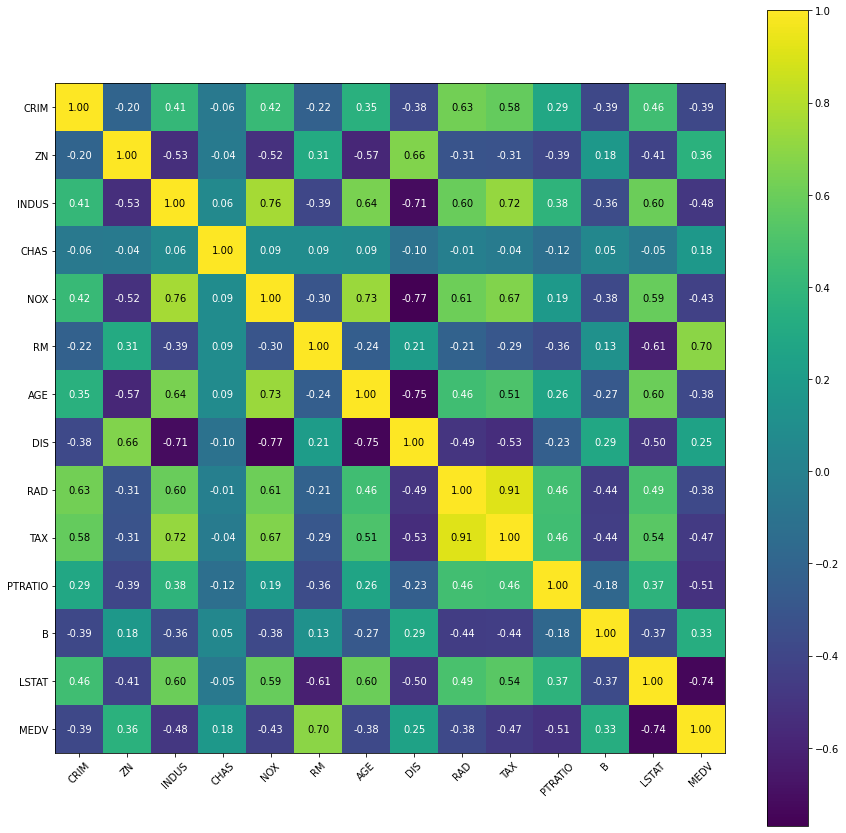

In [4]:
cm = np.corrcoef(df.values.T)
heatmap(cm, row_names=df.columns, column_names=df.columns, figsize=(15,15))

(<Figure size 1080x1080 with 2 Axes>, <AxesSubplot:>)

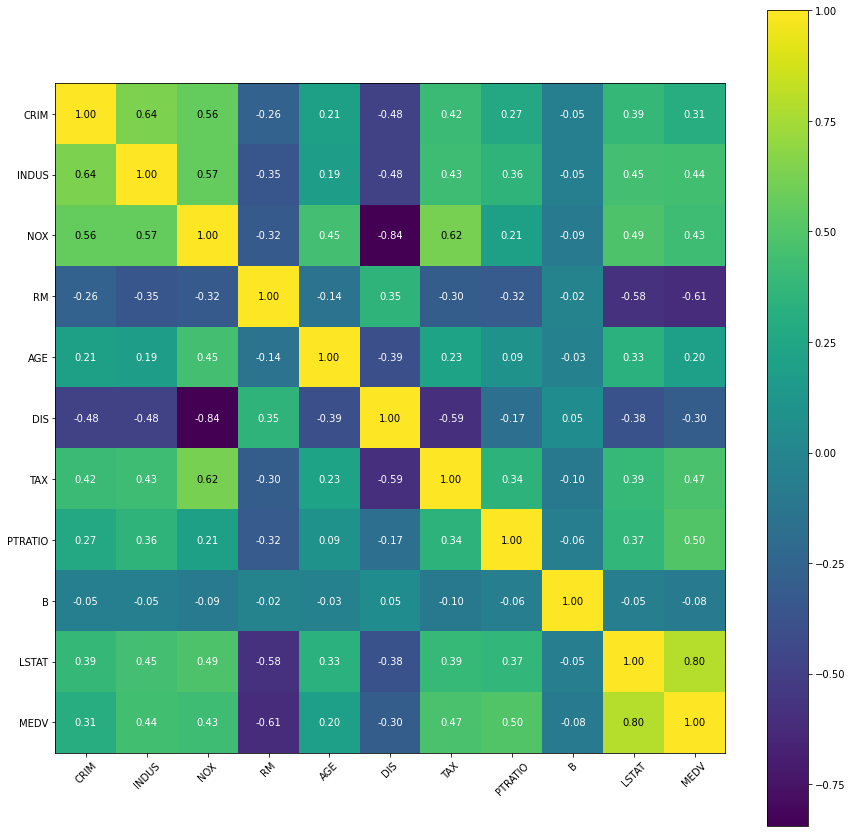

In [5]:
df_mod = df.copy()
tmp = 1 / df_mod.drop(columns=['ZN', 'CHAS', 'RAD', 'MEDV'])
tmp['MEDV'] = df['MEDV']
cm = np.corrcoef(tmp.values.T)
heatmap(cm, row_names=tmp.columns, column_names=tmp.columns, figsize=(15,15))

(<Figure size 1080x1080 with 2 Axes>, <AxesSubplot:>)

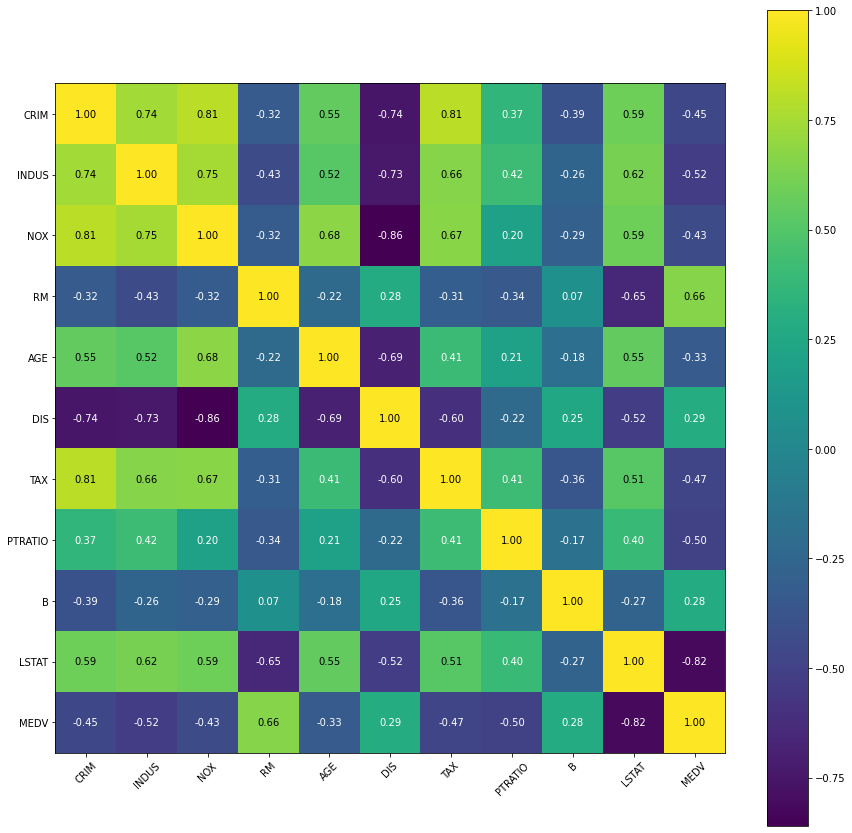

In [6]:
df_mod = df.copy()
tmp = df_mod.drop(columns=['ZN', 'CHAS', 'RAD', 'MEDV']).apply(np.log)
tmp['MEDV'] = df['MEDV']
cm = np.corrcoef(tmp.values.T)
heatmap(cm, row_names=tmp.columns, column_names=tmp.columns, figsize=(15,15))

In [7]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        self.w_history_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2
            self.cost_.append(cost)
            self.w_history_.append(self.w_.copy())
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)

In [8]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_std = sc_X.fit_transform(X)
lr = LinearRegressionGD()
lr.fit(X_std, y)

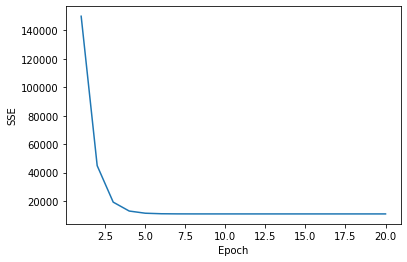

In [9]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

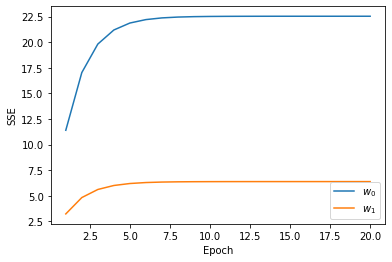

In [10]:
plt.plot(range(1, lr.n_iter+1), lr.w_history_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.legend(['$w_0$', '$w_1$'])
plt.show()

In [3]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

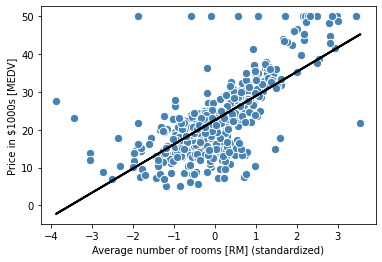

In [12]:
lin_regplot(X_std, y, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [13]:
lr.predict(sc_X.transform(np.array([[5.0]])))

array([10.83991601])

In [21]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


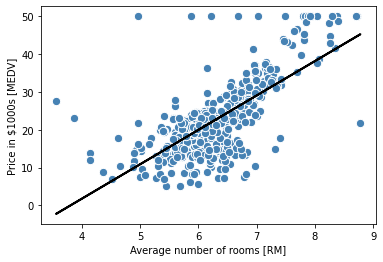

In [22]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [24]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        loss='absolute_loss',
                        residual_threshold=5,
                        random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5)

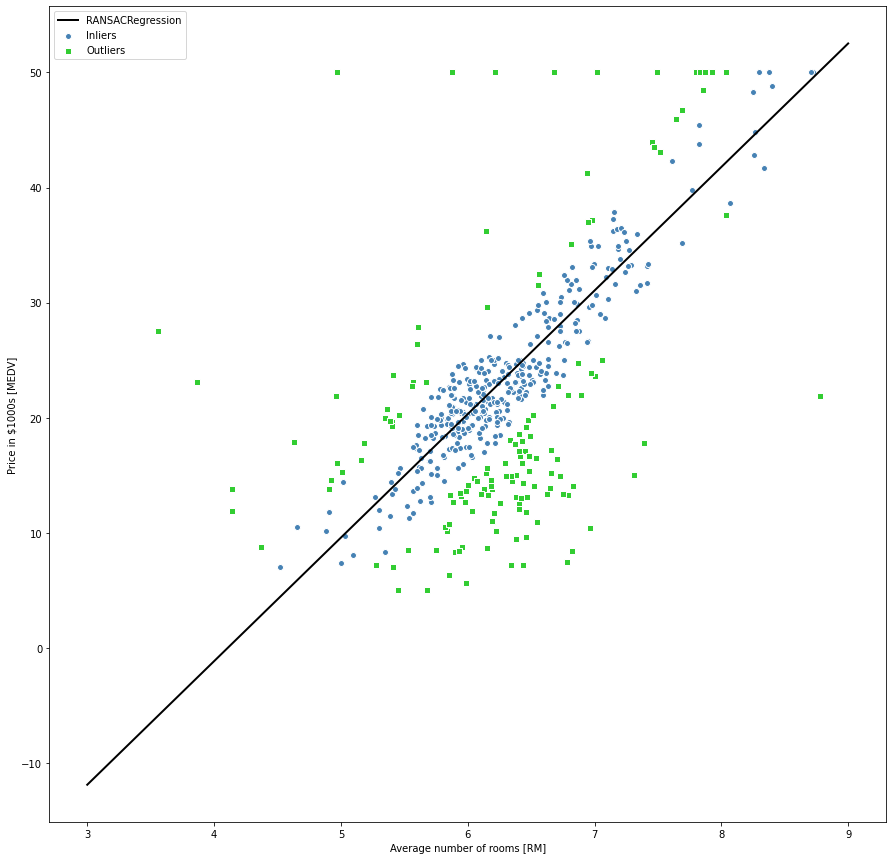

In [26]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.figure(figsize=(15,15))
plt.scatter(X[inlier_mask], y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2, label='RANSACRegression')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [28]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


In [29]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

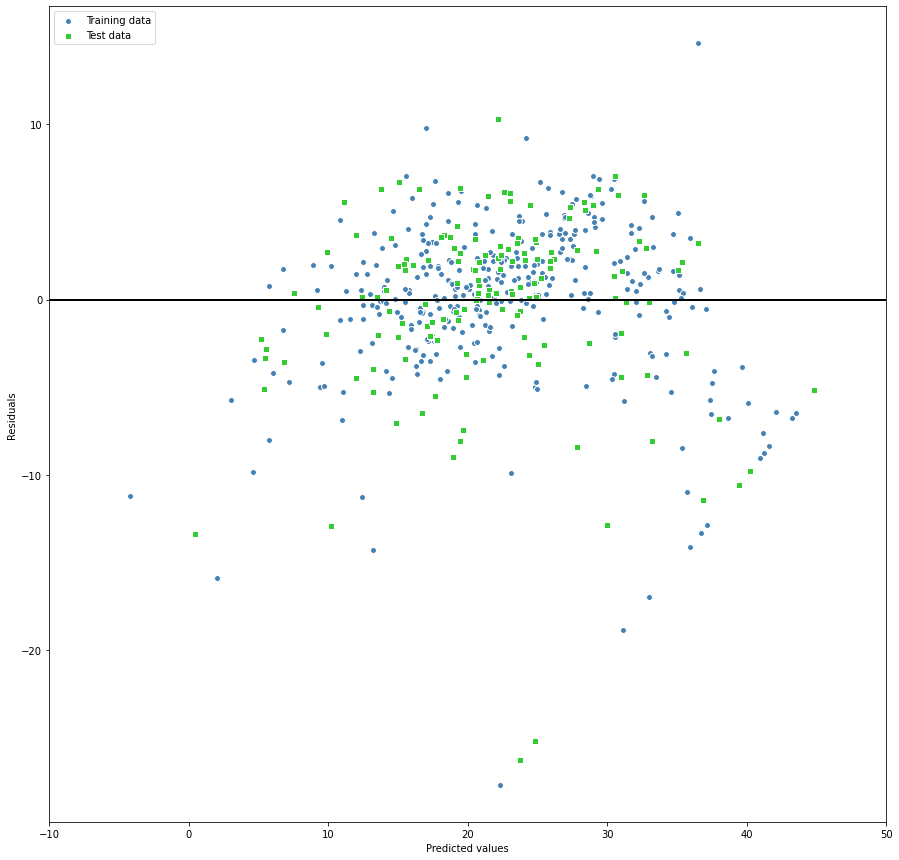

In [31]:
plt.figure(figsize=(15,15))
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [36]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


In [49]:
from sklearn.preprocessing import PolynomialFeatures
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
quartic = PolynomialFeatures(degree=4)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
X_quartic = quartic.fit_transform(X)

In [50]:
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

regr = regr.fit(X_quartic, y)
y_quartic_fit = regr.predict(quartic.fit_transform(X_fit))
quartic_r2 = r2_score(y, regr.predict(X_quartic))

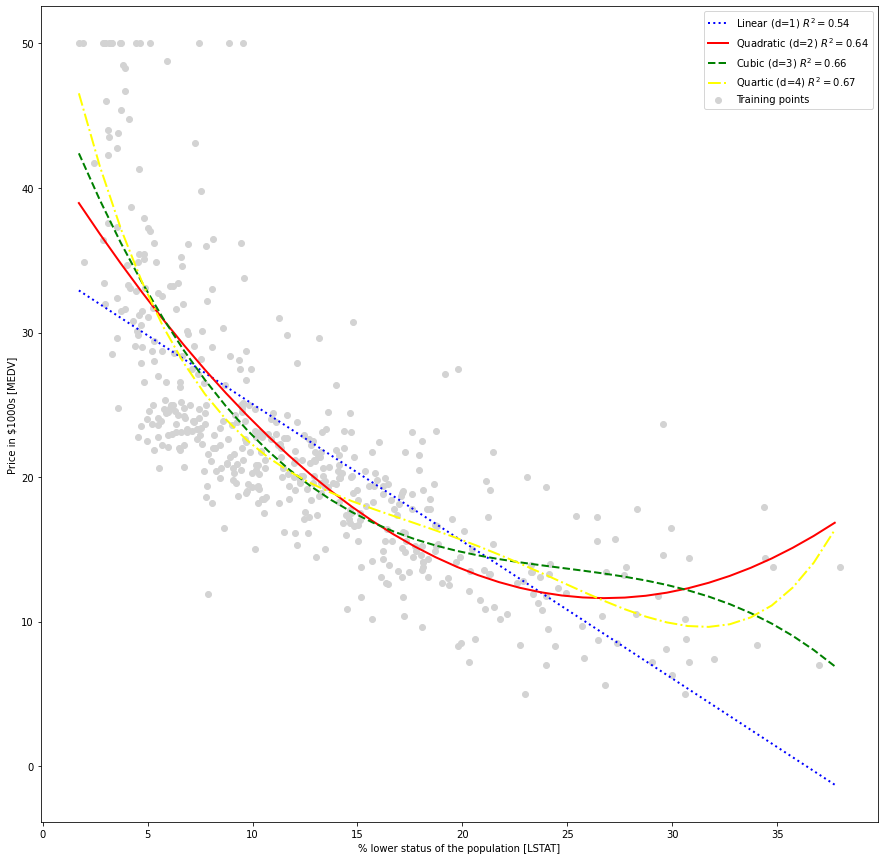

In [55]:
plt.figure(figsize=(15,15))
plt.scatter(X, y, label='Training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='Linear (d=1) $R^2=%.2f$' % linear_r2, color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='Quadratic (d=2) $R^2=%.2f$' % quadratic_r2, color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='Cubic (d=3) $R^2=%.2f$' % cubic_r2, color='green', lw=2, linestyle='--')
plt.plot(X_fit, y_quartic_fit, label='Quartic (d=4) $R^2=%.2f$' % quartic_r2, color='yellow', lw=2, linestyle='-.')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

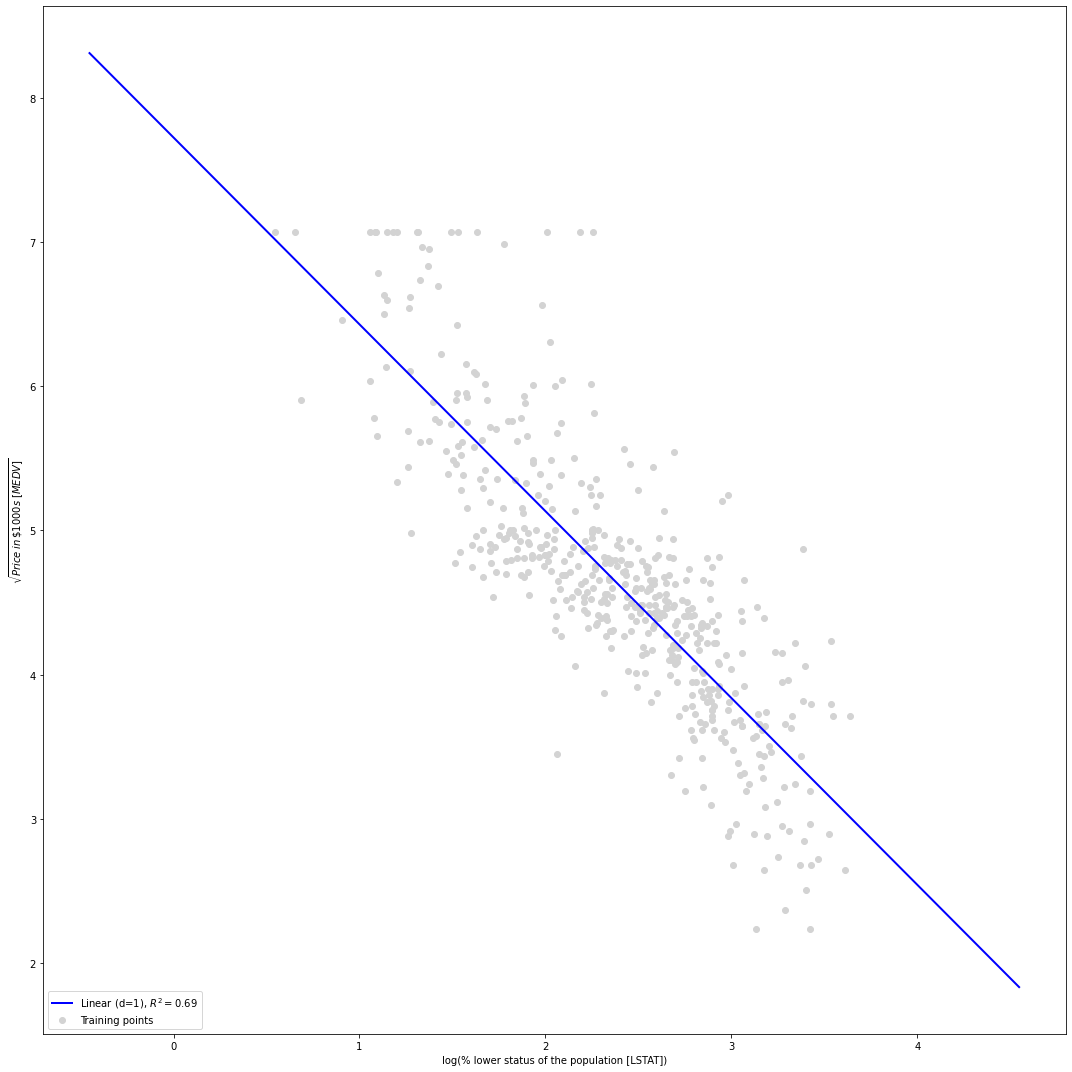

In [60]:
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.figure(figsize=(15,15))
plt.scatter(X_log, y_sqrt, label='Training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label='Linear (d=1), $R^2 = %.2f$' % linear_r2, color='blue', lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \, \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

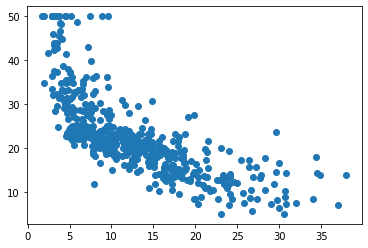

In [68]:
plt.scatter(df['LSTAT'], df['MEDV'])

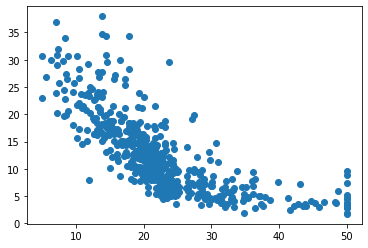

In [69]:
plt.scatter(df['MEDV'], df['LSTAT'])

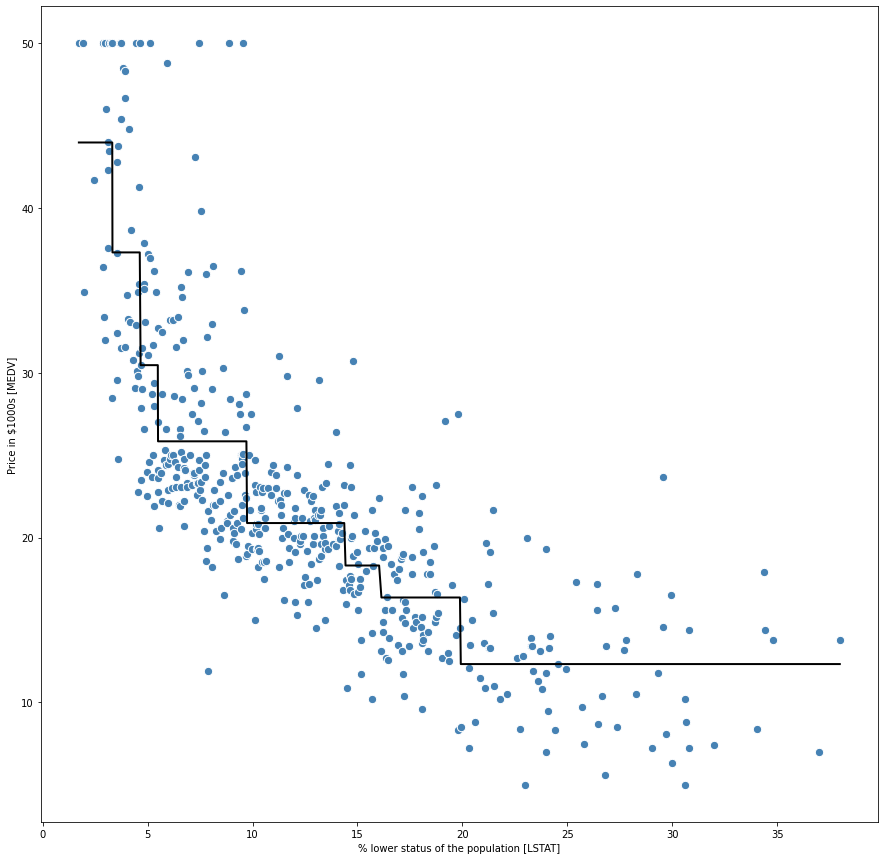

In [5]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
plt.figure(figsize=(15,15))
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 1.644, test: 11.085
R^2 train: 0.979, test: 0.877


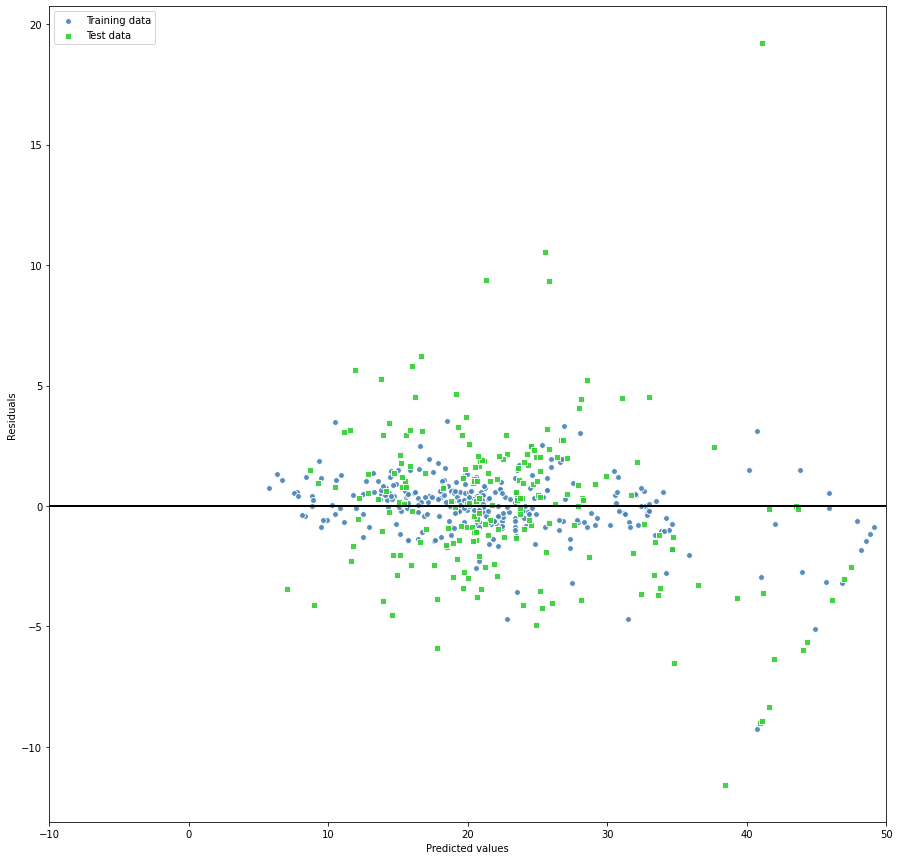

In [11]:
plt.figure(figsize=(15,15))
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', edgecolor='white', marker='o', s=35, alpha=0.9, label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', edgecolor='white', marker='s', s=35, alpha=0.9, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.show()